![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## </font> <font color = #4854E8> Objective </font>
We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

<div>
<img src="./Figures/dataset-cover.jpeg" width="1000"/>
</div>

![ML](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 1.1: </font> <font color = #41EA46> Import Libraries and Dataset </font>

We fetch the covertype data from OpenML: https://www.openml.org/d/180 

#### <font color = blue>Import the Libraries

In [2]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

%matplotlib inline
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
from tqdm import tqdm, tqdm_notebook
import seaborn as sns # Plotting library, install with 'pip install seaborn'

#### <font color = blue>Import the Dataset

In [3]:
covertype = openml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array'); 
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

/home/edouardo/.local/lib/python3.8/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
<ipython-input-3-14ef92dbc98b>:2: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');


In [4]:
classes

['Aspen',
 'Cottonwood_Willow',
 'Douglas_fir',
 'Krummholz',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Spruce_Fir']

In [5]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

### <font color = #27C3E5> 1.2: </font> <font color = #41EA46> Data Visualization </font>
To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

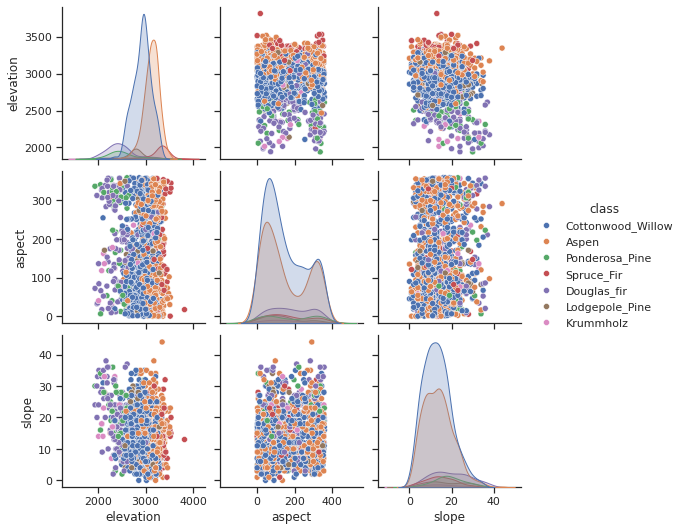

In [35]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class")

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## <font color = #950CDF> </font> <font color = #4854E8> Plotting helpers</font>

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

In [7]:
## Model solution
from IPython import display
def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 10))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### <font color = #27C3E5>  </font> <font color = #fd1b1b> Exercise 1: Random Forests</font>
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`). 
For the evaluation you should measure accuracy using 3-fold cross-validation. 
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotti

#### Solution

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier

def evaluate_RF(X, y, n_estimators, max_depth=[2,8,32,64], scoring='accuracy') :
  res = {}
  for md in max_depth:
    rf = RandomForestClassifier(n_estimators, max_depth=md, random_state=1)
    res['rf' + str(md)] = np.mean(cross_val_score(rf,X,y,cv=3, scoring=scoring))
  return res

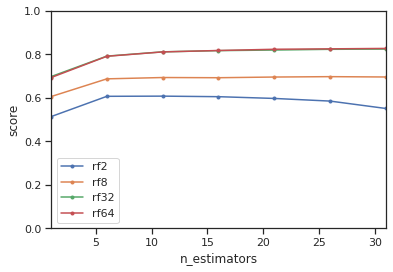

In [9]:
def plot_1(X, y, evaluator):
  Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.5, random_state=1)
  param_name = 'n_estimators'
  param_range = range(1, 32, 5)
  plot_live(Xs, ys, evaluator, param_name, param_range, scale = 'linear')
plot_1(X, y, evaluate_RF)

Nous observons que la profondeur 32 et 64 sont optimales, nous opterons pour 32, car 64 peut être un peu trop complexe.

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### <font color = #27C3E5>  </font> <font color = #fd1b1b> Exercise 2:  Other measures</font>
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

#### Solution

Nous déduisons donc de la question précédente, la profondeur optimale est 32.

In [10]:
def evaluate_RF2(X, y, n_estimators, max_depth=[32], scoring='balanced_accuracy') :
  res = {}
  for md in max_depth:
    rf = RandomForestClassifier(n_estimators, max_depth=md, random_state=1)
    res['rf' + str(md)] = np.mean(cross_val_score(rf,X,y,cv=3, scoring=scoring))
  return res

In [11]:
def plot_1(X, y, evaluator):
  Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.5, random_state=1)
  param_name = 'n_estimators'
  param_range = range(1, 32, 5)
  plot_live(Xs, ys, evaluator, param_name, param_range, scale = 'linear')

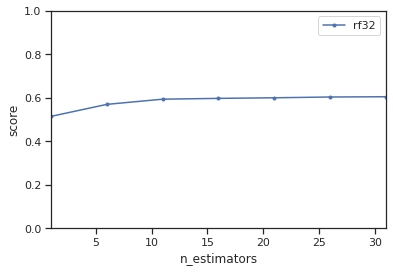

In [13]:
plot_1(X, y, evaluate_RF2)

"L'accuracy" mesure simplement la proportion d'échantillons correctement classés par le modèle. Cependant, cette mesure peut être trompeuse dans des situations où les classes de l'ensemble de données sont déséquilibrées. Concernant le "Balanced Accuracy", cette métrique prend en compte les taux de vrai positif pour chaque classe et calcule une moyenne pondérée. Elle est particulièrement utile lorsque les classes sont déséquilibrées, car elle offre une mesure plus équilibrée de la capacité du modèle à bien performer sur toutes les classes, même celles qui sont minoritaires. Une fois que nous savons cela, il est facilement déduisable, que le nombre d'estimateurs optimale est 30, c'est la ou le score est le plus haute, avoisinant les 0.6, ce qui veux dire que le modéle indique une performance plutôt solide.

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5>  </font> <font color = #fd1b1b> Exercise 3 : Feature importance</font>
Retrieve the feature importances according to the (tuned) random forest model. Which feature are most important?

#### Solution

Le meilleur modèle semble être celui avec 30 estimateurs et de profondeur maximum 32.

In [40]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

In [13]:
forest_classifier = RandomForestClassifier(n_estimators=30, max_depth=32, random_state=1)
forest_classifier.fit(X, y)
feature_importances = forest_classifier.feature_importances_
feature_indices = np.argsort(feature_importances)

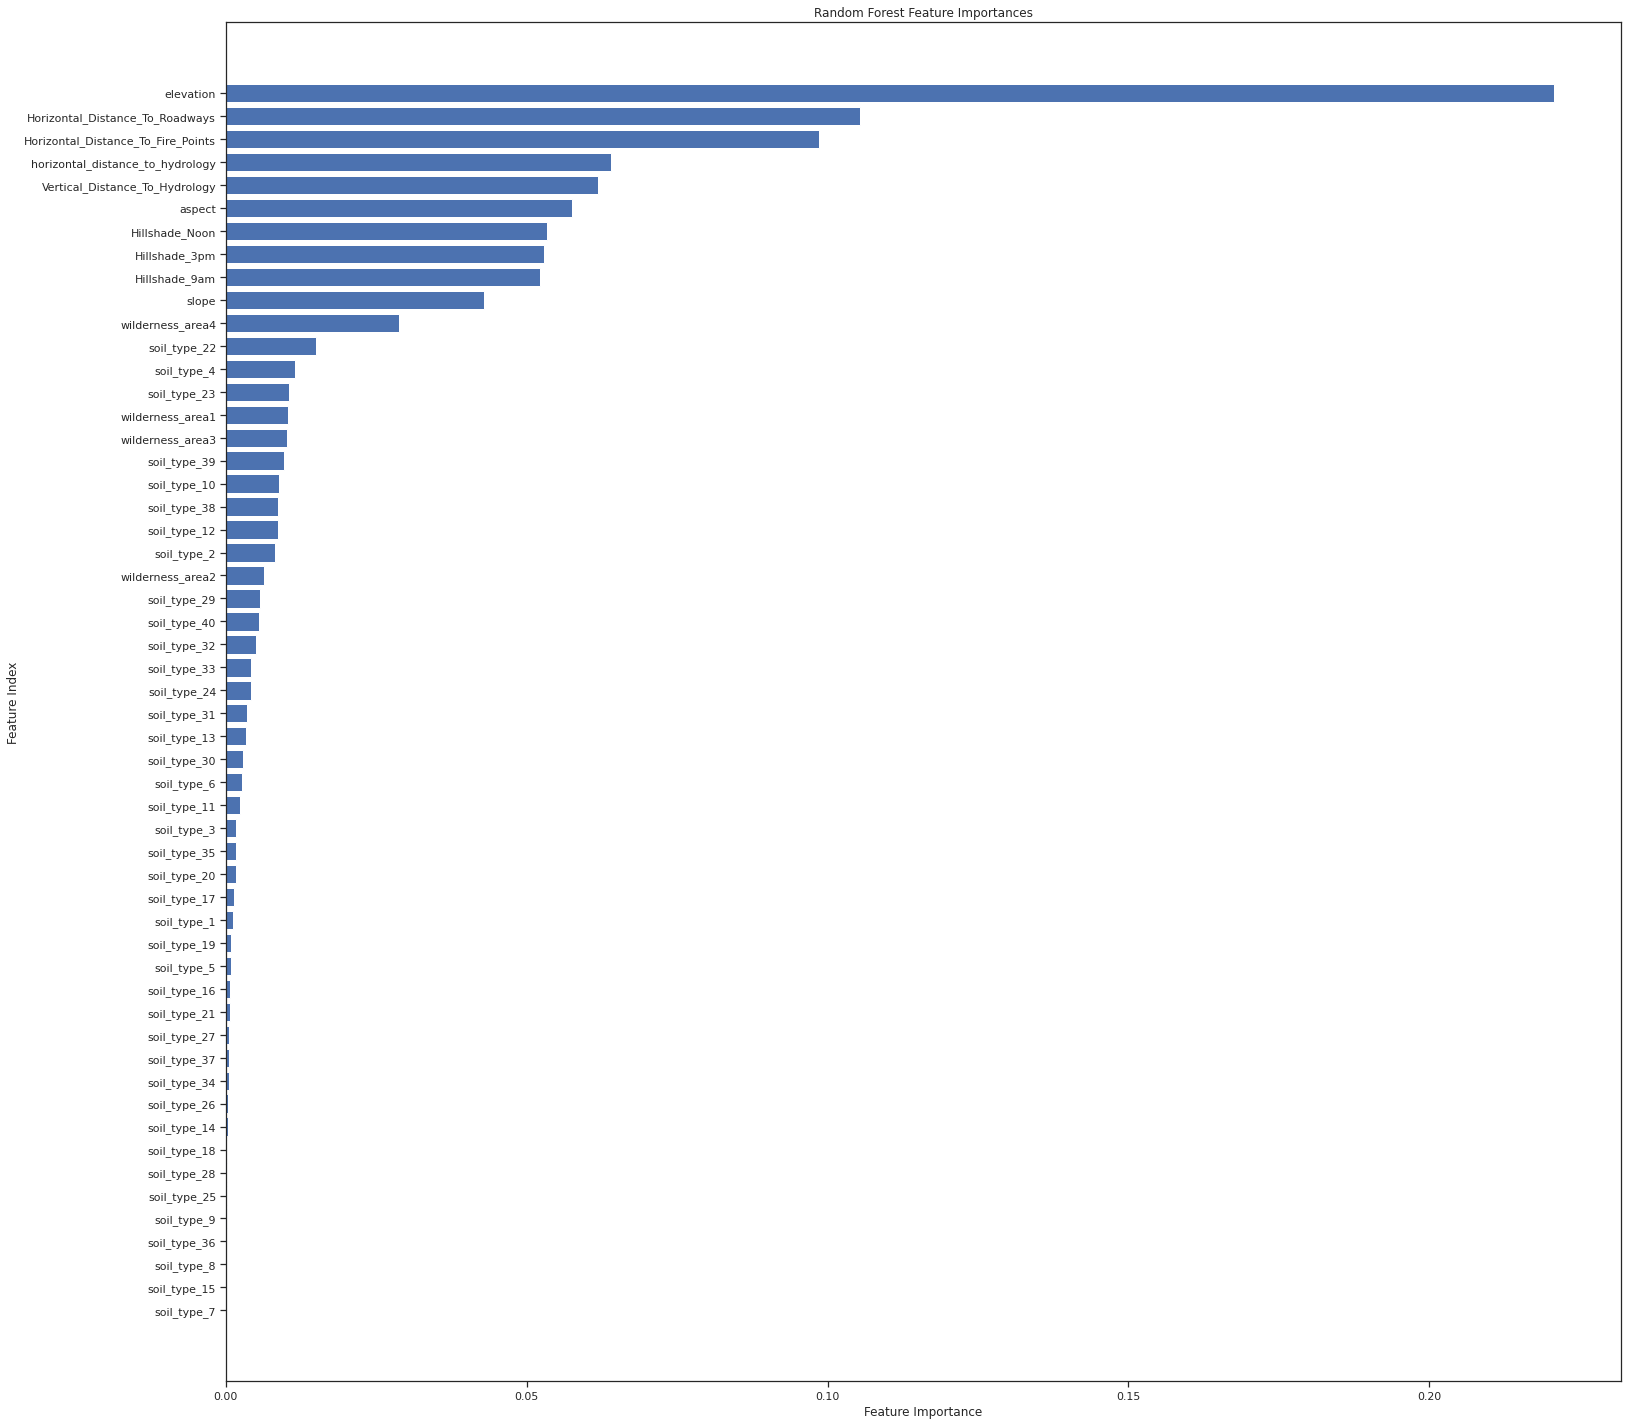

In [28]:
plt.figure(figsize=(25, 25))
plt.barh(range(len(feature_importances)), feature_importances[feature_indices])
plt.yticks(range(len(feature_importances)), [features[i] for i in feature_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('Random Forest Feature Importances')
plt.show()

L'altitude "elevation", est la caractéristiques la plus importante, et donc la plus influentes pour la prédiction faite par notre modèle et de loin. Les deux autres caractéristiques les plus influentes pour la prédiction, creusant un petit écart avec la quatrième caractéristique, sont la distance horizontale aux routes ainsi que la distance par rapport aux points d'incendie. Ce sont les 3 caractéristiques les plus importantes dans la prédiction de couverture forestière.

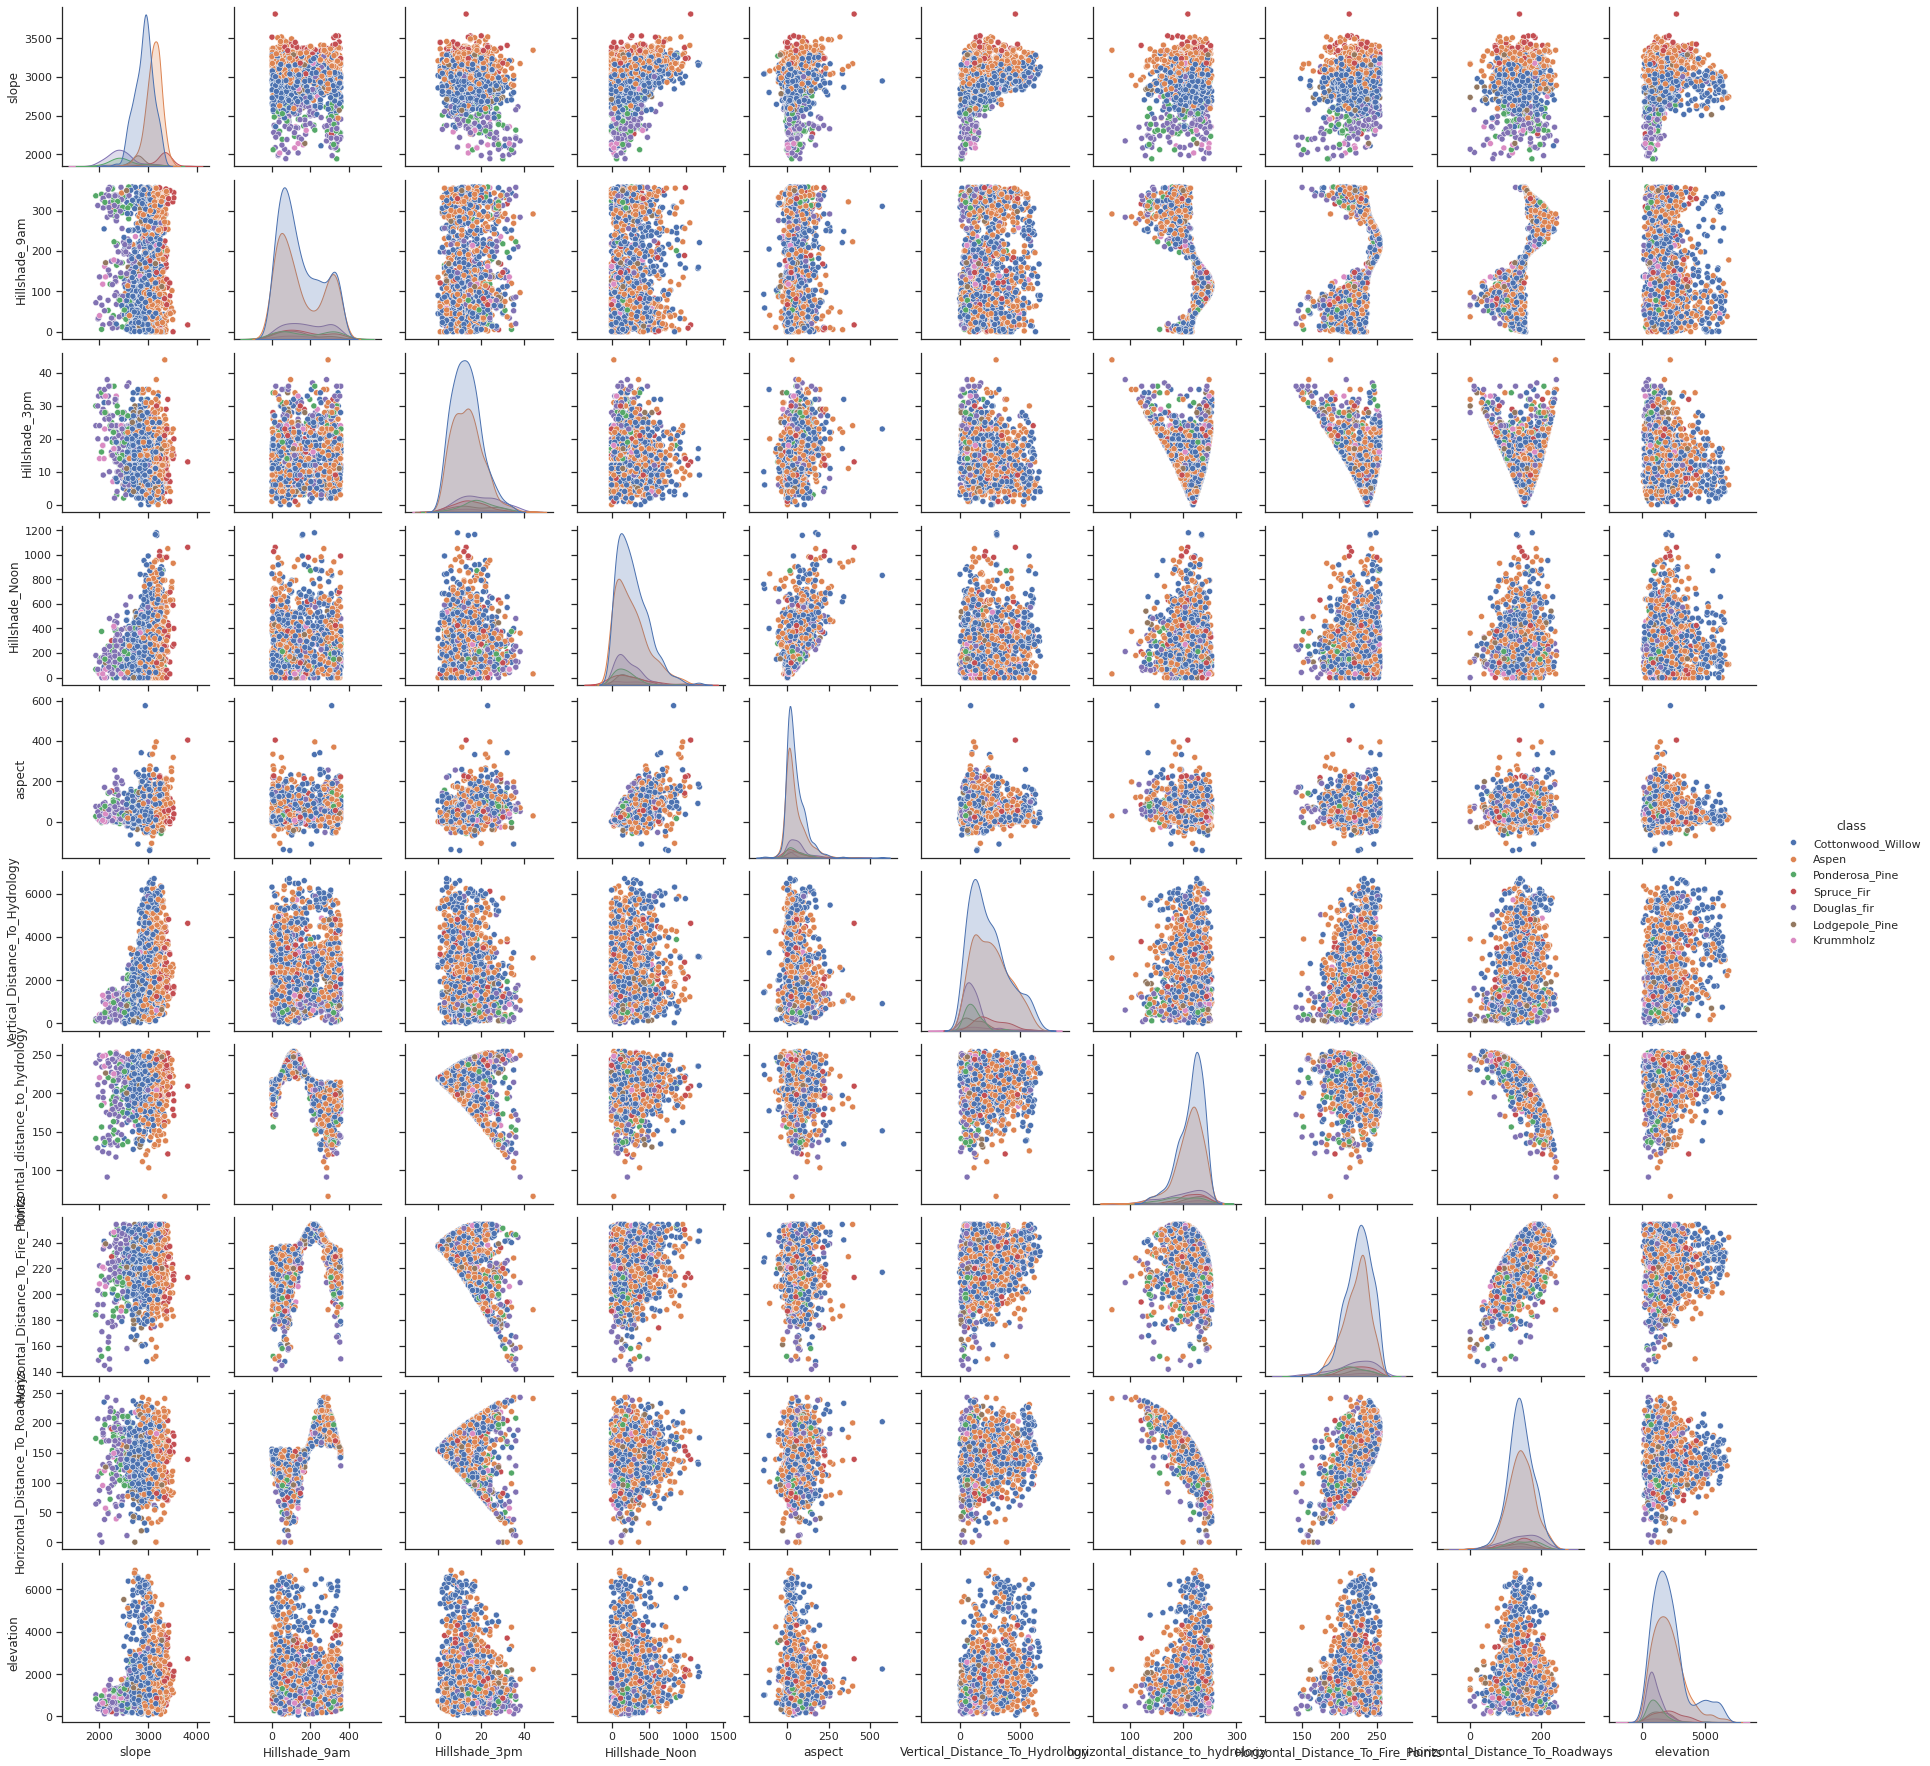

In [39]:
n_points = 1500
df = pd.DataFrame(X[:n_points,:10], columns=[features[i] for i in feature_indices][-10:])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class")

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### <font color = #27C3E5>  </font> <font color = #fd1b1b> Exercise 4 :  Feature selection </font>
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

#### Solution

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [48]:
tuned_rf_model = RandomForestClassifier(n_estimators=30, max_depth=32, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
tuned_rf_model.fit(X_train, y_train)
y_pred = tuned_rf_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

[[6782  843   26   17   33   21   59]
 [ 488 9679   54   22   26   43   24]
 [  65  131 1201    8    9   52    9]
 [  71   83   25   70    3   12    4]
 [  85  188   13    2  219   10    6]
 [  80  143   81    6    3  475    6]
 [ 133  101   11    2    8    6  641]]


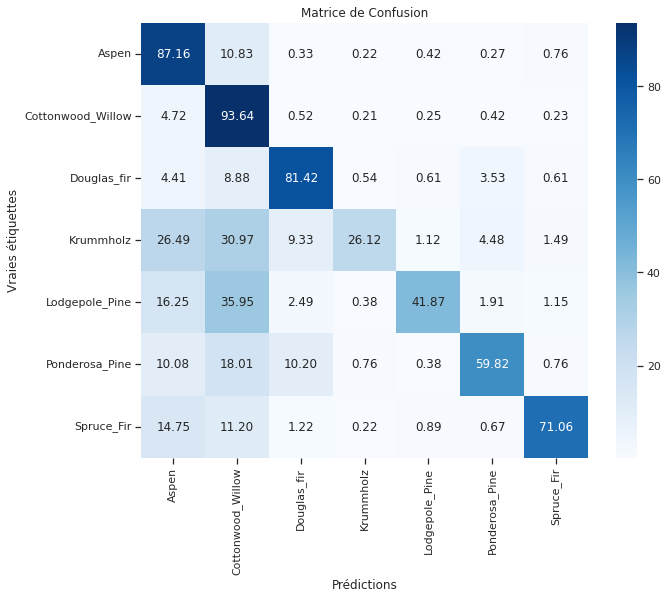

In [49]:
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", xticklabels=classes, yticklabels=classes, cmap="Blues", cbar=True)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

Nous pouvons observer que la classe "Aspen" est souvent confondu avec la classe "Cottonwood_Willow", mais on peut dire que c'est anecdotique tellement les bonnes prédictions sont nombreuses et largement supérieur. Par contre des classes sont confondues avec pas tellement de bonnes prédictions largement supérieur, c'est le cas pour les classes "Krummholz" et "Lodgepole_Pine", ou les pourcentages de mauvaises prédictions est supérieur à celui de bonne prédiction. Ces deux classes reste donc très souvent confondues.

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### <font color = #27C3E5>  </font> <font color = #fd1b1b> Exercise 5 : Confusion matrix </font>
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

#### Solution

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import time

In [50]:
X_subset = X[:, :10]
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, stratify=y, test_size=0.2, random_state=1)
start_time = time.time()
tuned_rf_model_subset = RandomForestClassifier(n_estimators=30, max_depth=32, random_state=1)
tuned_rf_model_subset.fit(X_train, y_train)
training_time = time.time() - start_time
y_pred_subset = tuned_rf_model_subset.predict(X_test)
balanced_acc_subset = balanced_accuracy_score(y_test, y_pred_subset)

In [51]:
print("Balanced Accuracy (using only the first 10 features):", balanced_acc_subset)
print("Training Time (using only the first 10 features):", training_time)

Balanced Accuracy (using only the first 10 features): 0.6358895357997129
Training Time (using only the first 10 features): 9.491250276565552


La précision équilibrée est une mesure de la précision qui prend en compte les déséquilibres entre les classes, on obtiens un score de 0.635, ce qui indique la capacité du modèle à bien performer sur l'ensemble des classes. Le modèle a pris 9.49 secondes pour s'entraîner. On peut considérer cela comme plutôt court car on a enlevé 10 caractéristiques et obtient a peu prés le même score que vu précedemment qui était également de 0.6 à peu prés. On peut en déduire qu'on peut se passer de caractéristiques assez peu importantes et garder les meilleurs, cela nous fait gagner du temps, ne fait pas perdre en performance, ce qui rend donc notre modçèle tout simplement plus efficace.

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5>  </font> <font color = #fd1b1b> Exercise 6 : Gradient Boosting</font>
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for 
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

#### Solution

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [54]:
def evaluate_GB(X, y, learning_rates=[0.01, 0.1, 1, 10], n_estimators_range=range(1, 101, 10), model='sklearn'):
    results = {}
    for lr in learning_rates:
        results[str(lr)] = list()
        for n_estimators in n_estimators_range:
            if model == 'sklearn':
                gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=lr, random_state=1)
            elif model == 'xgboost':
                gb = XGBClassifier(n_estimators=n_estimators, learning_rate=lr, random_state=1)

            score = np.mean(cross_val_score(gb, X, y, cv=3, scoring='accuracy'))
            results[str(lr)].append(score)
    return results

In [66]:
def plot_results(param_range, results, model):
    plt.figure(figsize=(10, 6))
    for key, score in results.items():
        plt.plot(list(range(1, 101, 10)), score, label=f'Learning Rate {key}')
    plt.title(model)
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [56]:
Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.05, random_state=1)

In [57]:
results_sklearn = evaluate_GB(Xs, ys, model='sklearn')
results_xgboost = evaluate_GB(Xs, ys, model='xgboost')

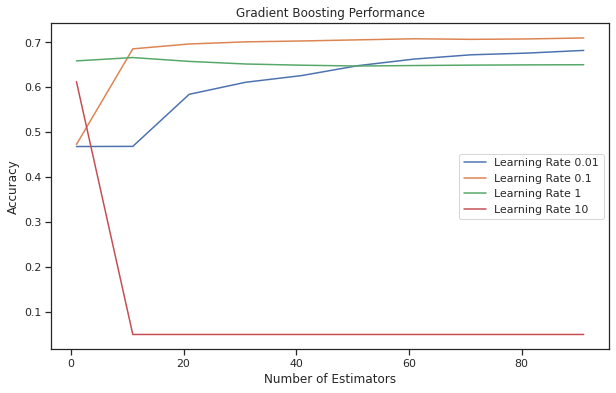

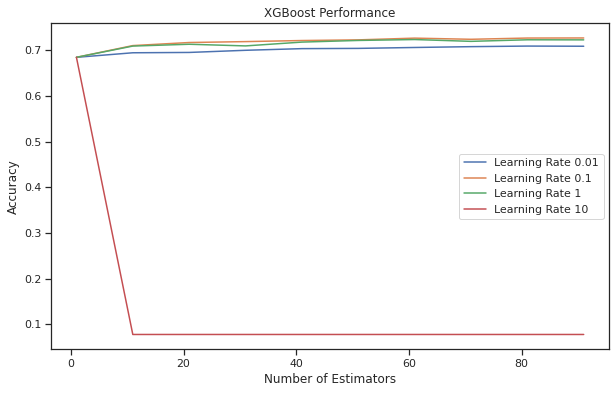

In [67]:
plot_results(list(range(1, 101, 10)), results_sklearn, 'Gradient Boosting Performance')
plot_results(list(range(1, 101, 10)), results_xgboost, 'XGBoost Performance')

On peut observer plusieurs choses sur ces graphiques. Premièrement, que ce soit pour les deux modèles, on remarque que si le taux d'apprentissage est trop haut, les performances ne sont pas bonnes. Et deuxièmement, on remarque que le modèle XGBoost a de meilleurs performance que Gradient Boosting, qui d'autant plus, pour un nombre d'estimateurs assez bas également, ce qui est non négligeable.